In [510]:
#libraries
import pandas as pd
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
import requests
from requests.auth import HTTPBasicAuth
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import PowerTransformer
import re
from deap import creator, base, tools, algorithms #GENETIC ALGORITHM LIBRARY - requirement: pip install deap
import random
from sklearn import metrics
from sklearn.pipeline import Pipeline
import imblearn
from imblearn.over_sampling import SMOTE

In [748]:
#read data sets
df = pd.read_csv("dev.csv") #DEV-SAMPLE
dfo = pd.read_csv("oot0.csv")#OUT-OF-TIME SAMPLE

In [749]:
#save target and id and then drop
y = df["ob_target"]
dfo_id = dfo["id"]

df = df.drop(["ob_target","id"], axis=1)
dfo = dfo.drop("id", axis=1)

# 1. EDA

In [750]:
df.columns

Index(['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5', 'ib_var_6',
       'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10', 'ib_var_11',
       'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15', 'ib_var_16',
       'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20', 'ib_var_21',
       'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25', 'ico_var_26',
       'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30', 'ico_var_31',
       'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35', 'ico_var_36',
       'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40', 'ico_var_41',
       'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45', 'ico_var_46',
       'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50', 'ico_var_51',
       'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55', 'ico_var_56',
       'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60', 'ico_var_61',
       'ico_var_62', 'ico_var_63', 'ico_var_64', 'if_var_65', 'if_var_66',
       'if_var_67

In [751]:
dfo.columns

Index(['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5', 'ib_var_6',
       'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10', 'ib_var_11',
       'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15', 'ib_var_16',
       'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20', 'ib_var_21',
       'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25', 'ico_var_26',
       'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30', 'ico_var_31',
       'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35', 'ico_var_36',
       'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40', 'ico_var_41',
       'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45', 'ico_var_46',
       'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50', 'ico_var_51',
       'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55', 'ico_var_56',
       'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60', 'ico_var_61',
       'ico_var_62', 'ico_var_63', 'ico_var_64', 'if_var_65', 'if_var_66',
       'if_var_67

#### Inspecting nulls

In [762]:
df.isna().sum().sort_values()

ib_var_1      0
ico_var_58    0
ico_var_57    0
ico_var_56    0
ico_var_55    0
             ..
icn_var_24    0
icn_var_23    0
icn_var_22    0
ico_var_40    0
if_var_81     0
Length: 81, dtype: int64

In [763]:
dfo.isna().sum().sort_values().tail(15)

ico_var_31     0
ico_var_30     0
ico_var_37     1
ico_var_33     1
ib_var_19      1
ico_var_26     1
ib_var_15      1
ib_var_16      1
ib_var_17      1
ib_var_18      1
ib_var_20      1
ib_var_21      1
if_var_78     15
icn_var_24    20
icn_var_22    72
dtype: int64

#### Inspecting our target variable

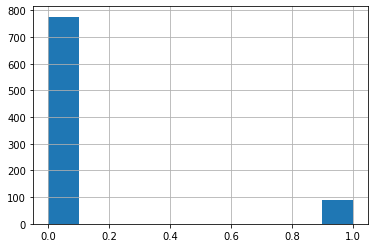

In [743]:
y.hist()

In [772]:
print(len(y[y==True])/len(y))

0.10185185185185185


## 2. Treating Null Rows

### 2.1 Removing rows where any column has a null value

In [621]:
dfo_with_nulls = dfo # copy of dfo

dfo_nulls = dfo[dfo.isnull().any(1)] #get all the rows where there are null values
null_cols = [col for col in dfo_nulls.columns if dfo_nulls[col].isnull().any()] #get columns where there are null values
dfo = dfo.dropna() #get new df without these rows

### 2.2 Define the function to obtain KS, which is the metric we will optimize in our models

In [575]:
def KS(b,a):  
    """Function that received two parameters; first: a binary variable representing 0=good and 1=bad, 
    and then a second variable with the prediction of the first variable, the second variable can be continuous, 
    integer or binary - continuous is better. Finally, the function returns the KS Statistics of the two lists."""
    try:
        tot_bads=1.0*sum(b)
        tot_goods=1.0*(len(b)-tot_bads)
        elements = zip(*[a,b])
        elements = sorted(elements,key= lambda x: x[0])
        elements_df = pd.DataFrame({'probability': b,'gbi': a})
        pivot_elements_df = pd.pivot_table(elements_df, values='probability', index=['gbi'], aggfunc=[sum,len]).fillna(0)
        max_ks = perc_goods = perc_bads = cum_perc_bads = cum_perc_goods = 0
        for i in range(len(pivot_elements_df)):
            perc_goods =  (pivot_elements_df.iloc[i]['len'] - pivot_elements_df.iloc[i]['sum']) / tot_goods
            perc_bads = pivot_elements_df.iloc[i]['sum']/ tot_bads
            cum_perc_goods += perc_goods
            cum_perc_bads += perc_bads
            A = cum_perc_bads-cum_perc_goods
            if abs(A['probability']) > max_ks:
                max_ks = abs(A['probability'])
    except:
        max_ks = 0
    return max_ks

my_func = make_scorer(KS, greater_is_better=True) #with the make scorer package we can define our own function to optimizize


In [576]:
#To optimize our model we will start with a very simple gridsearch, only tuning for the number of estimators

X = df
Xo = dfo

param_test = {
 'n_estimators':[1000,1500,2000],
}

rf = RandomForestClassifier(criterion = 'gini', 
                                #n_estimators = 100,
                                max_samples = 0.7,
                                min_samples_split = 0.001, 
                                min_samples_leaf = 0.0001,
                                max_leaf_nodes = 200, 
                                min_impurity_decrease = 0.0001,
                                random_state = 21,
                                class_weight = 'balanced')

gsearch = GridSearchCV(estimator = rf, 
                       param_grid = param_test, 
                       scoring=my_func, #### we will be optimizing by my_func !
                       n_jobs=4,
                       cv=3,
                       refit = True,
                       return_train_score = True)

fitted_model = gsearch.fit(X, y)
pred_dev = gsearch.best_estimator_.predict_proba(X)[:,1]
pred_oot  = gsearch.best_estimator_.predict_proba(Xo)[:,1]

print( gsearch.best_params_)
print( gsearch.best_score_)

gini_score = 2*roc_auc_score(y, pred_dev)-1
print ("GINI DEVELOPMENT=", gini_score)

KS_score = KS(y,pred_dev)
print("KS=",KS_score)

{'n_estimators': 1000}
0.0
GINI DEVELOPMENT= 1.0
KS= 0.9999999999999968


Now, lets add back those rows that we removed and predict all zeros on those rows, just for the moment.
At the end we will find a better way to fill the prediction on the rows with null values

In [577]:
dfo_index = pd.DataFrame(dfo_with_nulls.index) #get index of the dataframe which includes nulls
prediction_with_indexes = pd.DataFrame(dfo.index) #turn into dataframe
prediction_with_indexes["prediction"] = pred_oot #add the predicted values of the model without these rows
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left') #left join
new_df["prediction"].fillna(0, inplace=True) #fill na's with 0s
pred_oot = new_df["prediction"] #and we have our final prediction

#### And let's predict! Everytime we do a prediction we will repeat the process of adding back the rows with nulls and filling their predictions with 0's

### 2.3 Baseline Model

In [469]:
dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

RESULT SUBMISSION:  KS2 = 0.3791925064; GINI = 0.484386408377; GRADE = 8.986


## 3. More data cleaning ##

In [622]:
#### First, let's classify the variables according to their format

df_ib = df.loc[:,(df.columns.str.startswith("ib"))] #input binary
dfo_ib = dfo.loc[:,(dfo.columns.str.startswith("ib"))] #input binary

df_icn = df.loc[:,(df.columns.str.startswith("icn"))] #input categorical nominal
dfo_icn = dfo.loc[:,(dfo.columns.str.startswith("icn"))] #input categorical nominal

df_ico = df.loc[:,(df.columns.str.startswith("ico"))] #input categoricl ordinal
dfo_ico = dfo.loc[:,(dfo.columns.str.startswith("ico"))] #input categoricl ordinal

df_if = df.loc[:,(df.columns.str.startswith("if"))] #continuous
dfo_if = dfo.loc[:,(dfo.columns.str.startswith("if"))] #continuous


### 3.1 Scaling

In [623]:
## Scaling continuous variables

scaler = MinMaxScaler()
for column in df_if:
    scaler.fit(df_if[[column]])
    df[column]=scaler.transform(df_if[[column]])
    
for column in dfo_if:
    scaler.fit(dfo_if[[column]])
    dfo[column]=scaler.transform(dfo_if[[column]])
    

/Users/lina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [473]:
X = df
Xo = dfo

fitted_model = gsearch.fit(X, y)
pred_dev = gsearch.best_estimator_.predict_proba(X)[:,1]
pred_oot  = gsearch.best_estimator_.predict_proba(Xo)[:,1]

print( gsearch.best_params_)
print( gsearch.best_score_)

gini_score = 2*roc_auc_score(y, pred_dev)-1
print ("GINI DEVELOPMENT=", gini_score)

KS_score = KS(y,pred_dev)
print("KS=",KS_score)

dfo_index = pd.DataFrame(dfo_with_nulls.index)
prediction_with_indexes = pd.DataFrame(dfo.index)
prediction_with_indexes["prediction"] = pred_oot
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left')
new_df["prediction"].fillna(0, inplace=True)
pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

{'n_estimators': 1000}
0.8499556168660374
GINI DEVELOPMENT= 1.0
KS= 0.9999999999999968
RESULT SUBMISSION:  KS2 = 0.366635782216; GINI = 0.462929417093; GRADE = 8.688


### 3.2 Correcting skewness 

In [624]:
# detecting skewed variables 

def skewed_features(self, threshold=0.75, fix=False, return_series=True):

        df = self
        feature_skew = df.apply(
            lambda x: skew(x)).sort_values(ascending=False)

        if fix is True:
            high_skew = feature_skew[feature_skew > threshold]
            skew_index = high_skew.index
            for feature in skew_index:
                self = boxcox1p(
                    df[feature], boxcox_normmax(df[feature] + 1))
        if return_series is True:
            return feature_skew
        

skewed_features_t = pd.DataFrame(skewed_features(df_if)).reset_index()
skewed_features_t = skewed_features_t[(skewed_features_t[0]>0.75) | (skewed_features_t[0]<(-0.75))]

def skewed_features(self, threshold=0.75, fix=False, return_series=True):

        df = self
        feature_skew = df.apply(
            lambda x: skew(x)).sort_values(ascending=False)

        if fix is True:
            high_skew = feature_skew[feature_skew > threshold]
            skew_index = high_skew.index
            for feature in skew_index:
                self = boxcox1p(
                    df[feature], boxcox_normmax(df[feature] + 1))
        if return_series is True:
            return feature_skew
        
skewed_features_o = pd.DataFrame(skewed_features(dfo_if)).reset_index()
skewed_features_o = skewed_features_o[(skewed_features_o[0]>0.75) | (skewed_features_o[0]<(-0.75))]

In [625]:
pt = PowerTransformer(method='yeo-johnson')

for column in df_if:
    if column in skewed_features_t["index"].values:
        pt.fit(df_if[[column]])
        df[column]=pt.transform(df_if[[column]])
        
for column in dfo_if:
    if column in skewed_features_o["index"].values:
        pt.fit(dfo_if[[column]])
        dfo[column]=pt.transform(dfo_if[[column]])

/Users/lina/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/lina/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/lina/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/lina/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/lina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [477]:
X = df
Xo = dfo

fitted_model = gsearch.fit(X, y)
pred_dev = gsearch.best_estimator_.predict_proba(X)[:,1]
pred_oot  = gsearch.best_estimator_.predict_proba(Xo)[:,1]

print( gsearch.best_params_)
print( gsearch.best_score_)

gini_score = 2*roc_auc_score(y, pred_dev)-1
print ("GINI DEVELOPMENT=", gini_score)

KS_score = KS(y,pred_dev)
print("KS=",KS_score)

dfo_index = pd.DataFrame(dfo_with_nulls.index)
prediction_with_indexes = pd.DataFrame(dfo.index)
prediction_with_indexes["prediction"] = pred_oot
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left')
new_df["prediction"].fillna(0, inplace=True)
pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = 'http://**'
files = {'file': (filename, open(filename, 'rb'))}

"""

"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

{'n_estimators': 1000}
0.8499556168660374
GINI DEVELOPMENT= 1.0
KS= 0.9999999999999968
RESULT SUBMISSION:  KS2 = 0.376176073716; GINI = 0.469355077219; GRADE = 8.914


### 3.3 One hot encoding

In [588]:
#df_dummies = pd.get_dummies(df, columns = df_ib.columns,drop_first=True)
#dfo_dummies = pd.get_dummies(dfo, columns = df_ib.columns,drop_first=True)

df_dummies = pd.get_dummies(df, columns = df_icn.columns, drop_first=True) 
dfo_dummies = pd.get_dummies(dfo, columns = df_icn.columns, drop_first=True) 

#df = pd.get_dummies(df, columns = df_ico.columns,drop_first=True)
#dfo = pd.get_dummies(dfo, columns = df_ico.columns,drop_first=True)


In [589]:
Xo, X = dfo_dummies.align(df_dummies, join='inner', axis=1)

In [590]:
fitted_model = gsearch.fit(X, y)
pred_dev = gsearch.best_estimator_.predict_proba(X)[:,1]
pred_oot  = gsearch.best_estimator_.predict_proba(Xo)[:,1]

print( gsearch.best_params_)
print( gsearch.best_score_)

gini_score = 2*roc_auc_score(y, pred_dev)-1
print ("GINI DEVELOPMENT=", gini_score)

KS_score = KS(y,pred_dev)
print("KS=",KS_score)

dfo_index = pd.DataFrame(dfo_with_nulls.index)
prediction_with_indexes = pd.DataFrame(dfo.index)
prediction_with_indexes["prediction"] = pred_oot
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left')
new_df["prediction"].fillna(0, inplace=True)
pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

{'n_estimators': 1000}
0.0
GINI DEVELOPMENT= 1.0
KS= 0.9999999999999968
RESULT SUBMISSION:  KS2 = 0.362224928142; GINI = 0.458978363941; GRADE = 8.584


## 4. Feature Selection : Genetic Algorithm

In [626]:
df["ob_target"] = y #let's add back y to our dataset as it is required for the algorithm

Using script provided by professor

In [627]:
in_model = []
list_ib = set()  #input binary
list_icn = set() #input categorical nominal
list_ico = set() #input categorical ordinal
list_if = set()  #input numerical continuos (input float)
list_inputs = set()
output_var = 'ob_target'

for var_name in df.columns:
    if re.search('^ib_',var_name):
        list_inputs.add(var_name)      
        list_ib.add(var_name)
        print (var_name,"is input binary")
    elif re.search('^icn_',var_name):
        list_inputs.add(var_name)      
        list_icn.add(var_name)
        print (var_name,"is input categorical nominal")
    elif re.search('^ico_',var_name):
        list_inputs.add(var_name)      
        list_ico.add(var_name)
        print (var_name,"is input categorical ordinal")
    elif re.search('^if_',var_name):
        list_inputs.add(var_name)      
        list_if.add(var_name)
        print (var_name,"is input numerical continuos (input float)")
    elif re.search('^ob_',var_name):
        output_var = var_name
    else:
        print ("ERROR: unable to identify the type of:", var_name)
        

ib_var_1 is input binary
ib_var_2 is input binary
ib_var_3 is input binary
ib_var_4 is input binary
ib_var_5 is input binary
ib_var_6 is input binary
ib_var_7 is input binary
ib_var_8 is input binary
ib_var_9 is input binary
ib_var_10 is input binary
ib_var_11 is input binary
ib_var_12 is input binary
ib_var_13 is input binary
ib_var_14 is input binary
ib_var_15 is input binary
ib_var_16 is input binary
ib_var_17 is input binary
ib_var_18 is input binary
ib_var_19 is input binary
ib_var_20 is input binary
ib_var_21 is input binary
icn_var_22 is input categorical nominal
icn_var_23 is input categorical nominal
icn_var_24 is input categorical nominal
ico_var_25 is input categorical ordinal
ico_var_26 is input categorical ordinal
ico_var_27 is input categorical ordinal
ico_var_28 is input categorical ordinal
ico_var_29 is input categorical ordinal
ico_var_30 is input categorical ordinal
ico_var_31 is input categorical ordinal
ico_var_32 is input categorical ordinal
ico_var_33 is input cat

In [628]:
#####
#SETING UP THE GENETIC ALGORITHM and CALCULATING STARTING POOL (STARTING CANDIDATE POPULATION)
#####
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(list_inputs))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
def evalOneMax(individual):
    return sum(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

NPOPSIZE = 50 #RANDOM STARTING POOL SIZE
population = toolbox.population(n=NPOPSIZE)


/Users/lina/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/lina/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Running algorithm with a RF classifier

In [629]:
#####
#ASSESSING GINI ON THE STARTING POOL
#####
dic_gini={}
for i in range(np.shape(population)[0]): 

    # TRASLATING DNA INTO LIST OF VARIABLES (1-81)
    var_model = []    
    for j in range(np.shape(population)[0]): 
        if (population[i])[j]==1:
            var_model.append(list(list_inputs)[j])

    # ASSESSING GINI INDEX FOR EACH INVIVIDUAL IN THE INITIAL POOL 
            
    X_train=df[var_model]
    Y_train=df[output_var]

    ######
    # CHANGE_HERE - START: YOU ARE VERY LIKELY USING A DIFFERENT TECHNIQUE BY NOW. SO CHANGE TO YOURS.
    #####             
    rf = RandomForestClassifier(random_state=1)
    model=rf.fit(X_train,Y_train)   
    Y_predict=model.predict(X_train)
    ######
    # CHANGE_HERE - END: YOU ARE VERY LIKELY USING A DIFFERENT TECHNIQUE BY NOW. SO CHANGE TO YOURS.
    #####             


    ######
    # CHANGE_HERE - START: HERE IT USES THE DEVELOPMENT GINI TO SELECT VARIABLES, YOU SHOULD A DIFFERENT GINI. EITHER THE OOT GINI OR THE SQRT(DEV_GINI*OOT_GINI)
    #####                
    fpr, tpr, thresholds = metrics.roc_curve(Y_train, Y_predict)
    auc = metrics.auc(fpr, tpr)
    gini_power = abs(2*auc-1)
    ######
    # CHANGE_HERE - END: HERE IT USES THE DEVELOPMENT GINI TO SELECT VARIABLES, YOU SHOULD A DIFFERENT GINI. EITHER THE OOT GINI OR THE SQRT(DEV_GINI*OOT_GINI)
    #####                
    
    gini=str(gini_power)+";"+str(population[j]).replace('[','').replace(', ','').replace(']','')
    dic_gini[gini]=population[j]   
list_gini=sorted(dic_gini.keys(),reverse=True)

In [630]:
#####
#GENETIC ALGORITHM MAIN LOOP - START
# - ITERATING MANY TIMES UNTIL NO IMPROVMENT HAPPENS IN ORDER TO FIND THE OPTIMAL SET OF CHARACTERISTICS (VARIABLES)
#####
sum_current_gini=0.0
sum_current_gini_1=0.0
sum_current_gini_2=0.0
first=0    
OK = 1
a=0
while OK:  #REPEAT UNTIL IT DO NOT IMPROVE, AT LEAST A LITLE, THE GINI IN 2 GENERATIONS
    a=a+1
    print ('loop ', a)
    OK=0

    ####
    # GENERATING OFFSPRING - START
    ####
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1) #CROSS-X PROBABILITY = 50%, MUTATION PROBABILITY=10%
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population =toolbox.select(offspring, k=len(population))
    ####
    # GENERATING OFFSPRING - END
    ####

    sum_current_gini_2=sum_current_gini_1
    sum_current_gini_1=sum_current_gini
    sum_current_gini=0.0

    #####
    #ASSESSING GINI ON THE OFFSPRING - START
    #####
    for j in range(np.shape(population)[0]): 
        if population[j] not in dic_gini.values(): 
            var_model = [] 
            for i in range(np.shape(population)[0]): 
                if (population[j])[i]==1:
                    var_model.append(list(list_inputs)[i])
            
            X_train=df[var_model]
            Y_train=df[output_var]
            
            ######
            # CHANGE_HERE - START: YOU ARE VERY LIKELY USING A DIFFERENT TECHNIQUE BY NOW. SO CHANGE TO YOURS.
            #####            
            rf = RandomForestClassifier(random_state=1)
            model=rf.fit(X_train,Y_train)   
            Y_predict=model.predict(X_train)
            ######
            # CHANGE_HERE - END: YOU ARE VERY LIKELY USING A DIFFERENT TECHNIQUE BY NOW. SO CHANGE TO YOURS.
            #####            
                       
            
            ######
            # CHANGE_HERE - START: HERE IT USES THE DEVELOPMENT GINI TO SELECT VARIABLES, YOU SHOULD A DIFFERENT GINI. EITHER THE OOT GINI OR THE SQRT(DEV_GINI*OOT_GINI)
            #####                       
            fpr, tpr, thresholds = metrics.roc_curve(Y_train, Y_predict)
            auc = metrics.auc(fpr, tpr)
            gini_power = abs(2*auc-1)
            ######
            # CHANGE_HERE - END: HERE IT USES THE DEVELOPMENT GINI TO SELECT VARIABLES, YOU SHOULD A DIFFERENT GINI. EITHER THE OOT GINI OR THE SQRT(DEV_GINI*OOT_GINI)
            #####                       
           
            gini=str(gini_power)+";"+str(population[j]).replace('[','').replace(', ','').replace(']','')
            dic_gini[gini]=population[j]  
    #####
    #ASSESSING GINI ON THE OFFSPRING - END
    #####

    #####
    #SELECTING THE BEST FITTED AMONG ALL EVER CREATED POPULATION AND CURRENT OFFSPRING - START
    #####           
    list_gini=sorted(dic_gini.keys(),reverse=True)
    population=[]
    for i in list_gini[:NPOPSIZE]:
        population.append(dic_gini[i])
        gini=float(i.split(';')[0])
        sum_current_gini+=gini
    #####
    #SELECTING THE BEST FITTED AMONG ALL EVER CREATED POPULATION AND CURRENT OFFSPRING - END
    #####           
      
    #HAS IT IMPROVED AT LEAST A LITLE THE GINI IN THE LAST 2 GENERATIONS
    print ('sum_current_gini=', sum_current_gini, 'sum_current_gini_1=', sum_current_gini_1, 'sum_current_gini_2=', sum_current_gini_2)
    if(sum_current_gini>sum_current_gini_1+0.0001 or sum_current_gini>sum_current_gini_2+0.0001):
        OK=1
#####
#GENETIC ALGORITHM MAIN LOOP - END
#####


gini_max=list_gini[0]        
gini=float(gini_max.split(';')[0])
features=gini_max.split(';')[1]


####
# PRINTING OUT THE LIST OF FEATURES
#####
f=0
list_input=[] #empty list that will give us the features selected by the algorithm to use them in our model
for i in range(len(features)):
    if features[i]=='1':
        f+=1
        print ('feature ', f, ':', list(list_inputs)[i])
        list_input.append(list(list_inputs)[i])
print ('gini: ', gini)


loop  1
sum_current_gini= 26.988636363636363 sum_current_gini_1= 0.0 sum_current_gini_2= 0.0
loop  2
sum_current_gini= 35.977272727272734 sum_current_gini_1= 26.988636363636363 sum_current_gini_2= 0.0
loop  3
sum_current_gini= 40.977272727272734 sum_current_gini_1= 35.977272727272734 sum_current_gini_2= 26.988636363636363
loop  4
sum_current_gini= 45.977272727272734 sum_current_gini_1= 40.977272727272734 sum_current_gini_2= 35.977272727272734
loop  5
sum_current_gini= 50.0 sum_current_gini_1= 45.977272727272734 sum_current_gini_2= 40.977272727272734
loop  6
sum_current_gini= 50.0 sum_current_gini_1= 50.0 sum_current_gini_2= 45.977272727272734
loop  7
sum_current_gini= 50.0 sum_current_gini_1= 50.0 sum_current_gini_2= 50.0
feature  1 : ico_var_56
feature  2 : if_var_67
feature  3 : if_var_75
feature  4 : ib_var_3
feature  5 : if_var_70
feature  6 : ico_var_44
feature  7 : ico_var_29
feature  8 : ib_var_7
feature  9 : ico_var_58
feature  10 : ib_var_9
feature  11 : ib_var_1
feature  12 :

In [631]:
df = df.drop("ob_target", axis=1) #let's drop the target one more time

In [632]:
#using intersection of the list we created , lets do feature selection with the features selected by the algorithm
df = df[df.columns.intersection(list_input)]
dfo = dfo[dfo.columns.intersection(list_input)]
dfo_with_nulls = dfo_with_nulls[dfo_with_nulls.columns.intersection(list_input)]

In [633]:
#And align to make sure both X and Xo have the same columns
Xo, X = dfo.align(df, join='inner', axis=1)

In [634]:
#Let's fit and predict as usual
fitted_model = gsearch.fit(X, y)
pred_dev = gsearch.best_estimator_.predict_proba(X)[:,1]
pred_oot  = gsearch.best_estimator_.predict_proba(Xo)[:,1]

print( gsearch.best_params_)
print( gsearch.best_score_)

gini_score = 2*roc_auc_score(y, pred_dev)-1
print ("GINI DEVELOPMENT=", gini_score)

KS_score = KS(y,pred_dev)
print("KS=",KS_score)

dfo_index = pd.DataFrame(dfo_with_nulls.index)
prediction_with_indexes = pd.DataFrame(dfo.index)
prediction_with_indexes["prediction"] = pred_oot
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left')
new_df["prediction"].fillna(0, inplace=True)
pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

{'n_estimators': 1000}
0.0
GINI DEVELOPMENT= 1.0
KS= 0.9999999999999968
RESULT SUBMISSION:  KS2 = 0.376178384273; GINI = 0.480022920729; GRADE = 8.914


## 5. Oversampling using Smote ###

In [635]:
# Define the resampling method
method = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X,y)

In [636]:
fitted_model = gsearch.fit(X_resampled, y_resampled)
pred_dev = gsearch.best_estimator_.predict_proba(X_resampled)[:,1]
pred_oot  = gsearch.best_estimator_.predict_proba(Xo)[:,1]

print( gsearch.best_params_)
print( gsearch.best_score_)

gini_score = 2*roc_auc_score(y_resampled, pred_dev)-1
print ("GINI DEVELOPMENT=", gini_score)

KS_score = KS(y_resampled,pred_dev)
print("KS=",KS_score)

dfo_index = pd.DataFrame(dfo_with_nulls.index)
prediction_with_indexes = pd.DataFrame(dfo.index)
prediction_with_indexes["prediction"] = pred_oot
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left')
new_df["prediction"].fillna(0, inplace=True)
pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

{'n_estimators': 1500}
0.8750660959963286
GINI DEVELOPMENT= 1.0
KS= 0.9999999999999968
RESULT SUBMISSION:  KS2 = 0.337341380235; GINI = 0.444719914232; GRADE = 7.994


# 6. Putting everything on a pipeline

### 6.1 Pipeline with optimal hyperparameters and no SMOTE

In [644]:
# Tune only for the count vectorizer parameters
#smote_rf = Pipeline([('smote', SMOTE()),

smote_rf = Pipeline([ 
                      ('rf', RandomForestClassifier(criterion = 'entropy', 
                                #n_estimators = 100,
                                #max_samples = 0.7,
                                oob_score=True,
                                #max_depth = 20, 
                                min_samples_split = 2, 
                                #min_samples_leaf = 0.0001,
                                #max_leaf_nodes = 200,
                                bootstrap = True,
                                max_features='log2',
                                #min_impurity_decrease = 0.0001,
                                random_state = 21,
                                class_weight = 'balanced')), ])

from sklearn.model_selection import GridSearchCV
#'smote__sampling_strategy':[0.01,0.1,0.2],

parameters = {
              'rf__n_estimators':[10000],
               'rf__min_samples_leaf':[1],
                 }
#smote__sampling_strategy':[0.01],
gs_clf = GridSearchCV(smote_rf, 
                       param_grid = parameters, 
                       scoring=my_func,
                       n_jobs=5,
                       cv=5,
                       refit = True,
                       return_train_score = True)
gs_clf = gs_clf.fit(X,y)
print(gs_clf.best_score_)
print(gs_clf.best_params_)


0.0
{'rf__min_samples_leaf': 1, 'rf__n_estimators': 10000}


In [645]:
pred_dev = gs_clf.best_estimator_.predict_proba(X)[:,1]
pred_oot  = gs_clf.best_estimator_.predict_proba(Xo)[:,1]
KS_score = KS(y,pred_dev)
print("KS=",KS_score)

dfo_index = pd.DataFrame(dfo_with_nulls.index)
prediction_with_indexes = pd.DataFrame(dfo.index)
prediction_with_indexes["prediction"] = pred_oot
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left')
new_df["prediction"].fillna(0, inplace=True)
pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

KS= 0.999999999999997
RESULT SUBMISSION:  KS2 = 0.395833140787; GINI = 0.494102302239; GRADE = 9.38


In [650]:
dfo_tosend.to_csv("0.395833140787.csv")

### 6.2 Pipeline with optimal hyperparameters and SMOTE

#### Let's give smote one more chance and do some gridsearch, keeping the best performing RF hyperparameters and only optimizing our SMOTE strategy

In [665]:
smote_rf = Pipeline([ ('smote', SMOTE(random_state=3)),
                      ('rf', RandomForestClassifier(criterion = 'entropy', 
                                #n_estimators = 100,
                                #max_samples = 0.7,
                                oob_score=True,
                                #max_depth = 20, 
                                min_samples_split = 2, 
                                #min_samples_leaf = 0.0001,
                                #max_leaf_nodes = 200,
                                bootstrap = True,
                                max_features='log2',
                                #min_impurity_decrease = 0.0001,
                                random_state = 21)), ])

parameters = { 'smote__sampling_strategy':[0.2,0.25,0.3,0.35],'smote__k_neighbors':[1,2,3],
              'rf__n_estimators':[10000],
               'rf__min_samples_leaf':[1],
                 }
#smote__sampling_strategy':[0.01],
gs_clf = GridSearchCV(smote_rf, 
                       param_grid = parameters, 
                       scoring=my_func,
                       n_jobs=5,
                       cv=5,
                       refit = True,
                       return_train_score = True)
gs_clf = gs_clf.fit(X,y)
print(gs_clf.best_score_)
print(gs_clf.best_params_)


/Users/lina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.01240143369175628
{'rf__min_samples_leaf': 1, 'rf__n_estimators': 10000, 'smote__k_neighbors': 2, 'smote__sampling_strategy': 0.3}


In [666]:
pred_dev = gs_clf.best_estimator_.predict_proba(X)[:,1]
pred_oot  = gs_clf.best_estimator_.predict_proba(Xo)[:,1]
KS_score = KS(y,pred_dev)
print("KS=",KS_score)

dfo_index = pd.DataFrame(dfo_with_nulls.index)
prediction_with_indexes = pd.DataFrame(dfo.index)
prediction_with_indexes["prediction"] = pred_oot
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left')
new_df["prediction"].fillna(0, inplace=True)
pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

KS= 0.999999999999997
RESULT SUBMISSION:  KS2 = 0.355233181453; GINI = 0.480660634571; GRADE = 8.418


# 7. Ensemble Model

In [668]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

### I ensembled our best performing model along with a bagging classifier. It took almost 3 hours to run and the score did not improve.

In [695]:
kfold = model_selection.KFold(n_splits=3, random_state=7)
cart = RandomForestClassifier(criterion = 'entropy', 
                                n_estimators = 10000,
                                oob_score=True,
                                min_samples_split = 2, 
                                min_samples_leaf = 1,
                                bootstrap = True,
                                max_features='log2',
                                random_state = 21,
                                class_weight = 'balanced')
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees)
results = model_selection.cross_val_score(model, X, y, cv=kfold,scoring=my_func)
ensemble = model.fit(X,y)

/Users/lina/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [696]:
pred_dev = ensemble.predict_proba(X)[:,1]
pred_oot  = ensemble.predict_proba(Xo)[:,1]
KS_score = KS(y,pred_dev)
print("KS=",KS_score)

dfo_index = pd.DataFrame(dfo_with_nulls.index)
prediction_with_indexes = pd.DataFrame(dfo.index)
prediction_with_indexes["prediction"] = pred_oot
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left')
new_df["prediction"].fillna(0, inplace=True)
pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

KS= 0.9999999999999968
RESULT SUBMISSION:  KS2 = 0.382999149715; GINI = 0.479176101443; GRADE = 9.076


## 8. Back to our best model

In [697]:
smote_rf = Pipeline([ 
                      ('rf', RandomForestClassifier(criterion = 'entropy', 
                                #n_estimators = 100,
                                #max_samples = 0.7,
                                oob_score=True,
                                #max_depth = 20, 
                                min_samples_split = 2, 
                                #min_samples_leaf = 0.0001,
                                #max_leaf_nodes = 200,
                                bootstrap = True,
                                max_features='log2',
                                #min_impurity_decrease = 0.0001,
                                random_state = 21,
                                class_weight = 'balanced')), ])

from sklearn.model_selection import GridSearchCV
#'smote__sampling_strategy':[0.01,0.1,0.2],

parameters = {
              'rf__n_estimators':[10000],
               'rf__min_samples_leaf':[1],
                 }
#smote__sampling_strategy':[0.01],
gs_clf = GridSearchCV(smote_rf, 
                       param_grid = parameters, 
                       scoring=my_func,
                       n_jobs=5,
                       cv=5,
                       refit = True,
                       return_train_score = True)
gs_clf = gs_clf.fit(X,y)
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.0
{'rf__min_samples_leaf': 1, 'rf__n_estimators': 10000}


In [716]:
pred_dev = gs_clf.best_estimator_.predict_proba(X)[:,1]
pred_oot  = gs_clf.best_estimator_.predict_proba(Xo)[:,1]
KS_score = KS(y,pred_dev)
print("KS=",KS_score)

dfo_index = pd.DataFrame(dfo_with_nulls.index)
prediction_with_indexes = pd.DataFrame(dfo.index)
prediction_with_indexes["prediction"] = pred_oot
new_df = pd.merge(dfo_index,prediction_with_indexes,  left_on=0, right_on=0, how='left')
new_df["prediction"].fillna(0, inplace=True)
pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

KS= 0.999999999999997
RESULT SUBMISSION:  KS2 = 0.395833140787; GINI = 0.494102302239; GRADE = 9.38


## 8.1 Back to the beginning : prediction for rows with null values

In [747]:
#Lets check the list with the rows with Nan values that we created at the very beginning of the exercise
null_cols

['ib_var_15',
 'ib_var_16',
 'ib_var_17',
 'ib_var_18',
 'ib_var_19',
 'ib_var_20',
 'ib_var_21',
 'icn_var_22',
 'icn_var_24',
 'ico_var_26',
 'ico_var_33',
 'ico_var_37',
 'if_var_78']

They are only a few columns! I iterated one by one changing prediction from 0 to 1 on each until the score improved, this will be the final score!

In [718]:
#change the prediction to 1 when each of these columns is na. 
for i in new_df.index:
    if i in dfo_nulls.index and pd.isna(dfo_nulls["ib_var_15"][i]) == True :
      new_df.at[i,"prediction"] =1

pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

RESULT SUBMISSION:  KS2 = 0.398158716809; GINI = 0.498628684184; GRADE = 9.435


In [719]:
dfo_tosend.to_csv("0.398158716809.csv")

In [720]:
for i in new_df.index:
    if i in dfo_nulls.index and pd.isna(dfo_nulls["icn_var_24"][i]) == True :
      new_df.at[i,"prediction"] =1

pred_oot = new_df["prediction"]

dfo_with_nulls["id"]=dfo_id
dfo_with_nulls['pred'] = pred_oot

dfo_tosend = dfo_with_nulls[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
url = '****'
files = {'file': (filename, open(filename, 'rb'))}

"""
To compete in this challenge, please create an user at my teaching website:
and replace below where it says:
* my_user_name_goes_here
* my_password_goes_here
"""
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('****', '****'))
resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

RESULT SUBMISSION:  KS2 = 0.398158716809; GINI = 0.498628684184; GRADE = 9.435
